# Data Intake & Preprocessing

**Goal**: Load raw images, correct EXIF orientation, convert to 4:3 via center-crop, and downscale to **800×600** (no upscaling). Save to `data/processed_images/`. Create a processing manifest and preview 8×8 grid overlays.

In [1]:
# Imports & paths (Pillow-only pipeline)
import os, glob, math, csv
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

from PIL import Image, ImageOps, ImageDraw
import matplotlib.pyplot as plt

# ⚠️ Assumes this notebook is inside the "notebooks/" folder at project root.
# If you run it from project root, it will still work (BASE = current dir).
cwd = Path.cwd()
BASE = cwd.parent if cwd.name.lower() == "notebooks" else cwd

DATA = BASE / "data"
RAW_DIR = DATA / "raw_images"
PROC_DIR = DATA / "processed_images"
MANIFEST_CSV = DATA / "preprocess_manifest.csv"

TARGET_W, TARGET_H = 800, 600  # do not upscale smaller images

print("Base:", BASE)
print("Raw dir:", RAW_DIR)
print("Processed dir:", PROC_DIR)

Base: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project
Raw dir: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\data\raw_images
Processed dir: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\data\processed_images


## 1) Environment check

In [2]:
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROC_DIR.mkdir(parents=True, exist_ok=True)

files = sorted(glob.glob(str(RAW_DIR / "*")))
print("Raw images found:", len(files))

pd.DataFrame({"file": [os.path.basename(f) for f in files]}).head(10)

Raw images found: 465


,file
0,100820081692.jpg
1,100820081693.jpg
2,100820081694.jpg
3,100820081695.jpg
4,141120142185.jpg
5,26102010062.jpg
6,29032008693.jpg
7,29032008695.jpg
8,29032008696.jpg
9,29032008701.jpg


## 2) Helper functions

In [3]:
def load_image_pil(path: str) -> Image.Image:
    """
    Load image with EXIF orientation corrected, return 3-channel RGB (PIL Image).
    """
    im = Image.open(path)
    im = ImageOps.exif_transpose(im)  # apply EXIF Orientation if present
    # Normalize modes
    if im.mode == "RGB":
        return im
    if im.mode in ("RGBA", "P", "CMYK", "LA"):
        return im.convert("RGB")
    if im.mode == "L":
        return im.convert("RGB")
    # Fallback
    return im.convert("RGB")

def to_4by3_center_crop_pil(im: Image.Image):
    """
    Center-crop to 4:3 without scaling. Returns (cropped_image, crop_box).
    crop_box = (left, top, right, bottom)
    """
    w, h = im.size
    target_ratio = 4 / 3
    ratio = w / h
    if abs(ratio - target_ratio) < 1e-6:
        return im, (0, 0, w, h)
    if ratio > target_ratio:
        # too wide → crop width
        new_w = int(target_ratio * h)
        left = (w - new_w) // 2
        box = (left, 0, left + new_w, h)
        return im.crop(box), box
    else:
        # too tall → crop height
        new_h = int(w / target_ratio)
        top = (h - new_h) // 2
        box = (0, top, w, top + new_h)
        return im.crop(box), box

def downscale_only_pil(im: Image.Image, target_w=800, target_h=600):
    """
    Resize only if either dimension is larger than target; never upscale.
    Returns (image, resized_flag).
    """
    w, h = im.size
    if w > target_w or h > target_h:
        return im.resize((target_w, target_h), Image.Resampling.LANCZOS), True
    return im, False

def overlay_grid_pil(im: Image.Image, n=8, line=1):
    """
    Return a copy with 8×8 grid lines and c01..c64 labels.
    """
    out = im.copy()
    draw = ImageDraw.Draw(out)
    w, h = out.size
    gw, gh = w // n, h // n

    # grid lines
    for j in range(1, n):
        x = j * gw
        draw.line([(x, 0), (x, h)], fill=(255, 255, 255), width=line)
    for i in range(1, n):
        y = i * gh
        draw.line([(0, y), (w, y)], fill=(255, 255, 255), width=line)

    # labels
    idx = 1
    for i in range(n):
        for j in range(n):
            cx = j * gw + gw // 2
            cy = i * gh + gh // 2
            label = f"c{idx:02d}"
            draw.text((cx - 14, cy - 6), label, fill=(255, 255, 255))
            idx += 1
    return out

## 3) Process all images

In [4]:
records = []
errors = []

for p in files:
    name = os.path.basename(p)
    rec = {"file": name}
    try:
        im = load_image_pil(p)
        w0, h0 = im.size
        rec.update({"orig_w": w0, "orig_h": h0})

        # 4:3 crop
        im_c, box = to_4by3_center_crop_pil(im)
        sx, sy, ex, ey = box
        rec.update({"crop_x": sx, "crop_y": sy, "crop_w": ex - sx, "crop_h": ey - sy})

        # downscale-only
        im_f, resized = downscale_only_pil(im_c, TARGET_W, TARGET_H)
        wf, hf = im_f.size
        rec.update({"final_w": wf, "final_h": hf, "resized": int(resized)})

        # save extension
        ext = os.path.splitext(name)[1].lower()
        out_name = name if ext in [".jpg", ".jpeg", ".png"] else os.path.splitext(name)[0] + ".png"
        out_path = PROC_DIR / out_name

        # Save (ensure RGB for JPEG)
        save_kwargs = {"quality": 95} if out_name.lower().endswith((".jpg", ".jpeg")) else {}
        im_f.save(out_path, **save_kwargs)

        rec["status"] = "ok"
    except Exception as e:
        rec["status"] = "error"
        rec["error"] = str(e)
        errors.append((name, str(e)))
    records.append(rec)

df = pd.DataFrame(records)
df.to_csv(MANIFEST_CSV, index=False)
print("Processed:", int((df["status"] == "ok").sum()), "/", len(df))
if errors:
    print("Errors:", len(errors))
df.head(10)

Processed: 465 / 465


,file,orig_w,orig_h,crop_x,crop_y,crop_w,crop_h,final_w,final_h,resized,status
0,100820081692.jpg,2592,1944,0,0,2592,1944,800,600,1,ok
1,100820081693.jpg,2592,1944,0,0,2592,1944,800,600,1,ok
2,100820081694.jpg,2592,1944,0,0,2592,1944,800,600,1,ok
3,100820081695.jpg,2592,1944,0,0,2592,1944,800,600,1,ok
4,141120142185.jpg,2592,1944,0,0,2592,1944,800,600,1,ok
5,26102010062.jpg,2592,1944,0,0,2592,1944,800,600,1,ok
6,29032008693.jpg,2592,1944,0,0,2592,1944,800,600,1,ok
7,29032008695.jpg,2592,1944,0,0,2592,1944,800,600,1,ok
8,29032008696.jpg,2592,1944,0,0,2592,1944,800,600,1,ok
9,29032008701.jpg,2592,1944,0,0,2592,1944,800,600,1,ok


## 4) Preview 8×8 grid overlays on processed images

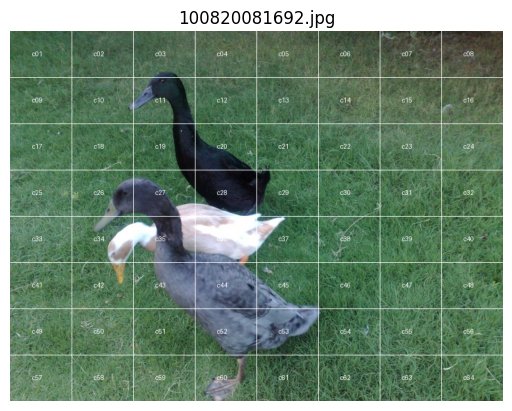

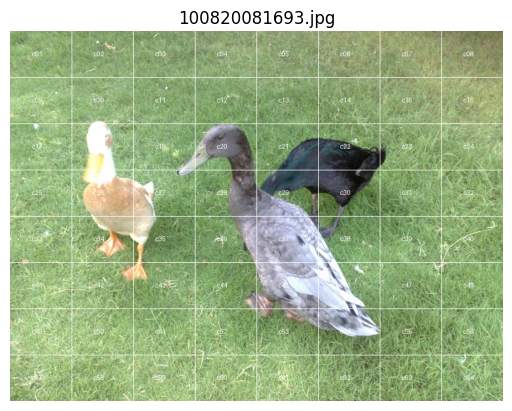

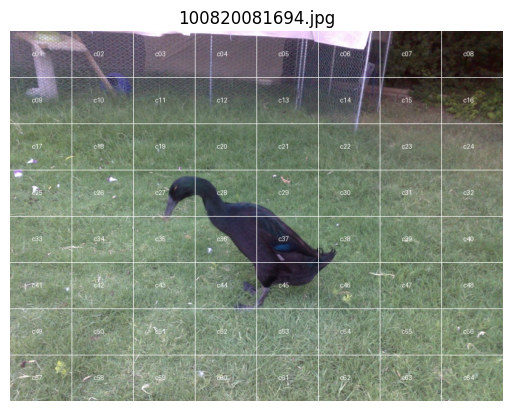

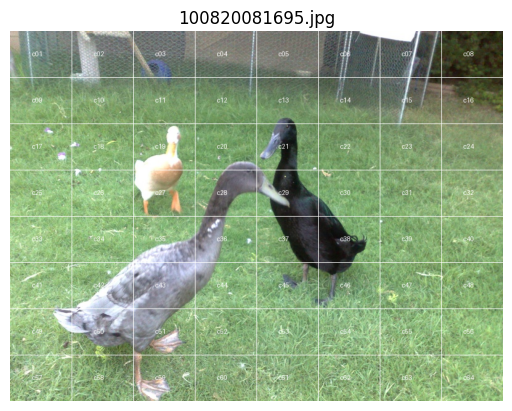

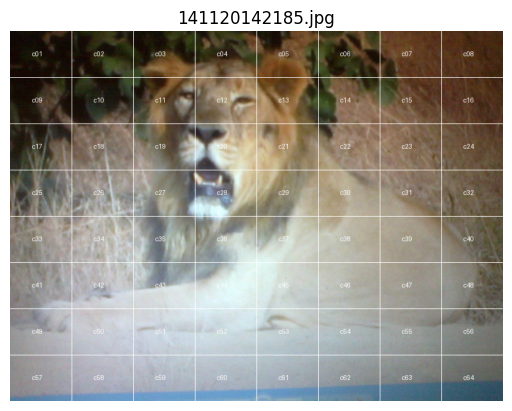

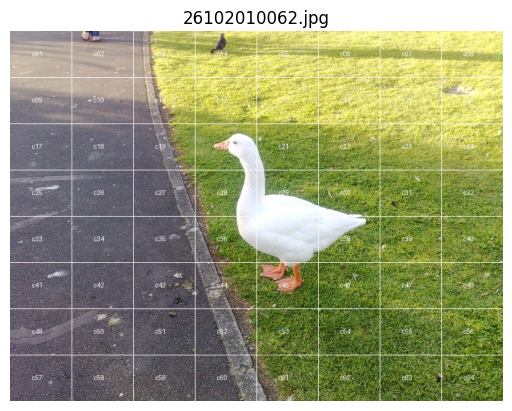

In [5]:
samples = sorted(glob.glob(str(PROC_DIR / "*")))[:6]

for s in samples:
    im = Image.open(s).convert("RGB")
    over = overlay_grid_pil(im, n=8, line=1)
    plt.figure()
    plt.imshow(over)
    plt.title(os.path.basename(s))
    plt.axis("off")

In [6]:
# ==== SUMMARY REPORT AFTER PREPROCESSING ====

manifest = pd.read_csv(MANIFEST_CSV)

print("===== IMAGE PROCESSING SUMMARY =====")
print(f"Total images found                : {len(manifest)}")

resized_count   = (manifest["resized"] == 1).sum()
same_count      = (manifest["resized"] == 0).sum()
error_count     = (manifest["status"] == "error").sum()
ok_count        = (manifest["status"] == "ok").sum()

print(f"Successfully processed            : {ok_count}")
print(f"Images resized (downscaled)      : {resized_count}")
print(f"Images kept same (no upscaling)  : {same_count}")
print(f"Images discarded (errors)        : {error_count}")
print("----------------------------------------")

# If crop_w or crop_h < original dimensions → crop happened
cropped = (manifest["crop_w"] < manifest["orig_w"]) | (manifest["crop_h"] < manifest["orig_h"])
cropped_count = cropped.sum()

print(f"Images center-cropped to 4:3     : {cropped_count}")

print("\n===== LIST OF DISCARDED IMAGES =====")
discarded = manifest[manifest["status"] == "error"]
if len(discarded) == 0:
    print("None")
else:
    display(discarded[["file", "error"]])

print("\n===== SUMMARY TABLE =====")
summary_df = manifest.assign(
    resized_flag = manifest["resized"].map({1:"Resized", 0:"Kept Same"}),
    crop_flag = np.where(
        (manifest["crop_w"] < manifest["orig_w"]) | (manifest["crop_h"] < manifest["orig_h"]),
        "Cropped",
        "No Crop Needed"
    )
)[["file","status","resized_flag","crop_flag","orig_w","orig_h","final_w","final_h"]]

display(summary_df.head(20))  # show first 20


===== IMAGE PROCESSING SUMMARY =====
Total images found                : 465
Successfully processed            : 465
Images resized (downscaled)      : 426
Images kept same (no upscaling)  : 39
Images discarded (errors)        : 0
----------------------------------------
Images center-cropped to 4:3     : 107

===== LIST OF DISCARDED IMAGES =====
None

===== SUMMARY TABLE =====


,file,status,resized_flag,crop_flag,orig_w,orig_h,final_w,final_h
0,100820081692.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
1,100820081693.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
2,100820081694.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
3,100820081695.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
4,141120142185.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
5,26102010062.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
6,29032008693.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
7,29032008695.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
8,29032008696.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
9,29032008701.jpg,ok,Resized,No Crop Needed,2592,1944,800,600


In [7]:
display(summary_df.head(465))  # show first 20

,file,status,resized_flag,crop_flag,orig_w,orig_h,final_w,final_h
0,100820081692.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
1,100820081693.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
2,100820081694.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
3,100820081695.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
4,141120142185.jpg,ok,Resized,No Crop Needed,2592,1944,800,600
...,...,...,...,...,...,...,...,...
460,p4.jpg,ok,Resized,Cropped,1146,1169,800,600
461,p6.jpg,ok,Resized,Cropped,962,769,800,600
462,p7.jpg,ok,Resized,Cropped,2279,1465,800,600
463,p8.jpg,ok,Resized,Cropped,801,833,800,600
